<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Enoncé" data-toc-modified-id="Enoncé-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Enoncé</a></span></li><li><span><a href="#Import-et-feature-engineering" data-toc-modified-id="Import-et-feature-engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import et feature engineering</a></span><ul class="toc-item"><li><span><a href="#Outils" data-toc-modified-id="Outils-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Outils</a></span></li><li><span><a href="#Application_train-et-Application-test" data-toc-modified-id="Application_train-et-Application-test-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Application_train et Application test</a></span></li><li><span><a href="#Bureau.csv-et-bureau_balance.csv" data-toc-modified-id="Bureau.csv-et-bureau_balance.csv-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Bureau.csv et bureau_balance.csv</a></span></li><li><span><a href="#previous_applications.csv,-POS_CASH_balance.csv,-installments_payments.csv,-credit_card_balance.csv" data-toc-modified-id="previous_applications.csv,-POS_CASH_balance.csv,-installments_payments.csv,-credit_card_balance.csv-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>previous_applications.csv, POS_CASH_balance.csv, installments_payments.csv, credit_card_balance.csv</a></span></li><li><span><a href="#Merge-des-fichiers-et-savegarde-du-fichier-final" data-toc-modified-id="Merge-des-fichiers-et-savegarde-du-fichier-final-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Merge des fichiers et savegarde du fichier final</a></span></li></ul></li><li><span><a href="#Bibliography" data-toc-modified-id="Bibliography-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bibliography</a></span></li></ul></div>

# Enoncé

# Import et feature engineering

Le notebook est basé sur https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/comments
et https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction#Conclusions

In [29]:
# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/comments
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
import re
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import joblib
import mlflow.sklearn

## Outils

In [30]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


Le dataset est décrit dans https://www.kaggle.com/competitions/home-credit-default-risk/data

## Application_train et Application test

Les 2 fichiers son mergés pour les traiter ensembles. Puis le outliers sont supprimés ou remplacés par nan (voir https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction#Conclusions). Après binarisation et one hot encoding, on calcule quelques nouveaux features.

In [31]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    #Les 2 fichiers sont mergés pour les traiter au meme temps
    df = df.append(test_df).reset_index()
    
    
    # Plot des prets qui ont été remboursées (0) ou pas (1)
    target_values = df['TARGET'].value_counts()/len(df)*100
    plt.pie(target_values,
            colors=['#228B22', '#FF0000'],
            autopct='%1.1f%%',
            labels=["0 - Solvable", "1 - Non Solvable"],
            startangle=90)
    plt.show()

    
    # Outliers: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    print

    # Outliers : NaN values for DAYS_EMPLOYED: 365.243 -> nan. Plus de details dans https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction#Conclusions
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Data Engineering Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    
    # Find correlations with the target and sort
    correlations = df.corr()['TARGET'].sort_values(ascending=False)

    # Display correlations
    print('Most Positive Correlations:\n', correlations.head(10))
    print('\nMost Negative Correlations:\n', correlations.tail(10))

    
    
    del test_df
    gc.collect()
    return df


Train samples: 5000, test samples: 5000


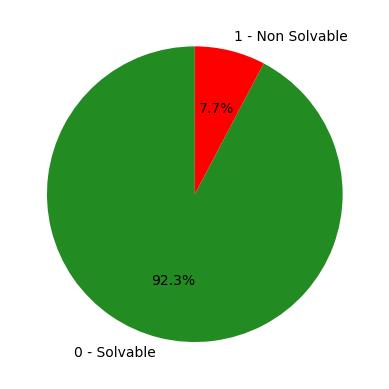

Most Positive Correlations:
 TARGET                                               1.000000
DAYS_EMPLOYED                                        0.095965
DAYS_ID_PUBLISH                                      0.070087
REGION_RATING_CLIENT_W_CITY                          0.067305
DEF_30_CNT_SOCIAL_CIRCLE                             0.066647
REGION_RATING_CLIENT                                 0.065906
NAME_INCOME_TYPE_Working                             0.065610
DAYS_BIRTH                                           0.065340
NAME_EDUCATION_TYPE_Secondary / secondary special    0.064754
DAYS_LAST_PHONE_CHANGE                               0.060659
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_1                   -0.147657
EXT_SOURCE_2                   -0.169843
EXT_SOURCE_3                   -0.213161
FLAG_MOBIL                           NaN
FLAG_DOCUMENT_2                      NaN
FLAG_DOCUMENT_4                      NaN
FLAG_DOCUMENT_7                      NaN
FLAG_

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4995,136103,NaN,1,0,0,0,157500.0,375367.5,38592.0,...,1,0,0,1,0,NaN,0.419589,157500.0,0.245029,0.102811
9996,4996,136114,NaN,1,0,0,1,67500.0,450000.0,15498.0,...,1,0,0,1,0,0.203238,0.150000,22500.0,0.229600,0.034440
9997,4997,136116,NaN,1,0,0,1,112500.0,707287.5,34155.0,...,0,0,0,0,0,0.143740,0.159058,56250.0,0.303600,0.048290
9998,4998,136140,NaN,1,0,1,0,202500.0,848745.0,36090.0,...,0,0,0,0,0,0.144456,0.238588,202500.0,0.178222,0.042522


In [32]:
application_train_test(5000)

## Bureau.csv et bureau_balance.csv

Les 2 fichiers sont importés, one hot encoded, agregés e mergés https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/comments . J'ai choisi la version "simple" du code avec min, max, mean, parce que je n'ai aucune competence métier. Il faudrait échanger avec un specialiste du domaine.



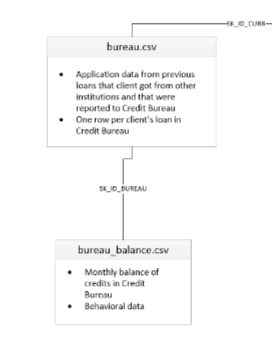

In [33]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


## previous_applications.csv, POS_CASH_balance.csv, installments_payments.csv, credit_card_balance.csv


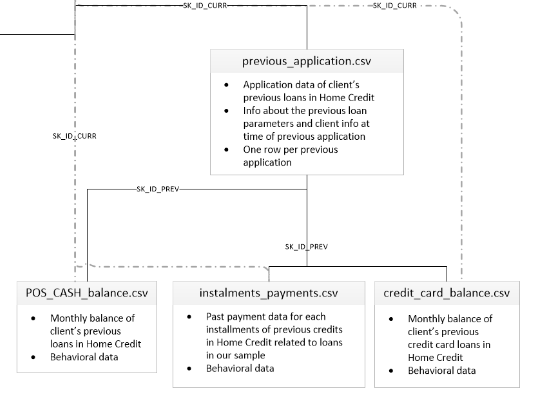

In [34]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

## Merge des fichiers et savegarde du fichier final

In [35]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    print("Dataframe shape",df.shape)
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Train Dataframe shape",train_df.shape)
    print("Test Dataframe shape",train_df.shape)
    
    # Find correlations with the target and sort
    correlations = df.corr()['TARGET'].sort_values(ascending=False)

    # Display correlations
    print('Most Positive Correlations:\n', correlations.head(10))
    print('\nMost Negative Correlations:\n', correlations.tail(10))

    # save Dataframe
    savedataframe = "debugdataframe.csv" if debug else "apidataframe.csv"
    print("Saving Dataframe",savedataframe)
    df.to_csv(savedataframe, index= False)


Train samples: 10000, test samples: 10000


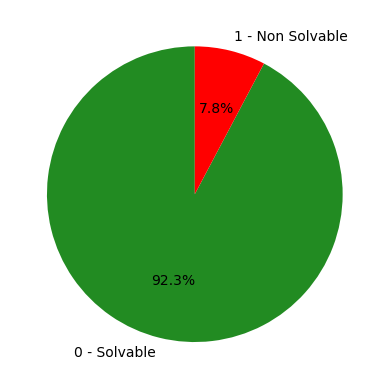

Most Positive Correlations:
 TARGET                                               1.000000
DAYS_BIRTH                                           0.093312
DAYS_EMPLOYED                                        0.087096
REGION_RATING_CLIENT_W_CITY                          0.071400
DAYS_ID_PUBLISH                                      0.070535
REGION_RATING_CLIENT                                 0.069991
DAYS_LAST_PHONE_CHANGE                               0.067106
NAME_INCOME_TYPE_Working                             0.060992
NAME_EDUCATION_TYPE_Secondary / secondary special    0.058399
REG_CITY_NOT_WORK_CITY                               0.054272
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_1                   -0.164953
EXT_SOURCE_2                   -0.170762
EXT_SOURCE_3                   -0.198362
FLAG_MOBIL                           NaN
FLAG_DOCUMENT_2                      NaN
FLAG_DOCUMENT_7                      NaN
FLAG_DOCUMENT_10                     NaN
FLAG_

In [36]:
main(debug = True)

TODO

* notebook data engineering

notebook models

notebook gridsearch hyperparametres

gridsearch personnalise :
cutoff, autre que f1. Considerer la marge. faire bouger le seuil et analyser la matrice de confusion. Faux negatif plus grave.

shap

dash

https://stackoverflow.com/questions/46208221/scikit-learn-gridsearch-custom-scoring-function
Lafforgue Théo
13:21
https://medium.com/analytics-vidhya/python-dash-data-visualization-dashboard-template-6a5bff3c2b76
Lafforgue Théo
13:21
https://github.com/ucg8j/awesome-dash
Lafforgue Théo
13:24
https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

# Bibliography



7ème dans le concours Kaggle

Kernel avec un meilleur AUC et un feature engineering métier mais assez long a entrainer.
https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

In [ ]:
"""
KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main ideia was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def main(debug= False):
    num_rows = 30000 if debug else None
    with timer("application_train and application_test"):
        df = get_train_test(DATA_DIRECTORY, num_rows= num_rows)
        print("Application dataframe shape: ", df.shape)
    with timer("Bureau and bureau_balance data"):
        bureau_df = get_bureau(DATA_DIRECTORY, num_rows= num_rows)
        df = pd.merge(df, bureau_df, on='SK_ID_CURR', how='left')
        print("Bureau dataframe shape: ", bureau_df.shape)
        del bureau_df; gc.collect()
    with timer("previous_application"):
        prev_df = get_previous_applications(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
        print("Previous dataframe shape: ", prev_df.shape)
        del prev_df; gc.collect()
    with timer("previous applications balances"):
        pos = get_pos_cash(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
        print("Pos-cash dataframe shape: ", pos.shape)
        del pos; gc.collect()
        ins = get_installment_payments(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
        print("Installments dataframe shape: ", ins.shape)
        del ins; gc.collect()
        cc = get_credit_card(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
        print("Credit card dataframe shape: ", cc.shape)
        del cc; gc.collect()
    # Add ratios and groupby between different tables
    df = add_ratios_features(df)
    df = reduce_memory(df)
    lgbm_categorical_feat = [
        'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
        'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']
    with timer("Run LightGBM"):
        feat_importance = kfold_lightgbm_sklearn(df, lgbm_categorical_feat)
        print(feat_importance)


def add_ratios_features(df):
    # CREDIT TO INCOME RATIO
    df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
    df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
    # PREVIOUS TO CURRENT CREDIT RATIO
    df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
    # PREVIOUS TO CURRENT ANNUITY RATIO
    df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
    df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
    df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
    df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
    df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']
    # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
    df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    # DAYS DIFFERENCES AND RATIOS
    df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']
    df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']
    return df


# ------------------------- LIGHTGBM MODEL -------------------------

def kfold_lightgbm_sklearn(data, categorical_feature = None):
    df = data[data['TARGET'].notnull()]
    test = data[data['TARGET'].isnull()]
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))
    del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
    predictors = list(filter(lambda v: v not in del_features, df.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['TARGET'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['TARGET'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['TARGET'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(df['TARGET'], oof_preds))
    test['TARGET'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Generate oof csv
        oof = pd.DataFrame()
        oof['SK_ID_CURR'] = df['SK_ID_CURR'].copy()
        df['PREDICTIONS'] = oof_preds.copy()
        df['TARGET'] = df['TARGET'].copy()
        df.to_csv('oof{}.csv'.format(SUBMISSION_SUFIX), index=False)
        # Save submission (test data) and feature importance
        test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
    return mean_importance


# ------------------------- APPLICATION PIPELINE -------------------------

def get_train_test(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)
    df = train.append(test)
    del train, test; gc.collect()
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    df = drop_application_columns(df)
    return df


def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df


def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0


# ------------------------- BUREAU PIPELINE -------------------------

def get_bureau(path, num_rows= None):
    """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

    # One-hot encoder
    bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
    # Join bureau balance features
    bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
    # Flag months with late payments (days past due)
    bureau['STATUS_12345'] = 0
    for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

    # Aggregate by number of months in balance and merge with bureau (loan length agg)
    features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
    agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
    agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
    bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
    del agg_length; gc.collect()

    # General loans aggregations
    agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
    del active, closed; gc.collect()
    # Aggregations for the main loan types
    for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
        type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
        prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
        agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
        del type_df; gc.collect()
    # Time based aggregations: last x months
    for time_frame in [6, 12]:
        prefix = "BUREAU_LAST{}M_".format(time_frame)
        time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
        agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
        del time_frame_df; gc.collect()

    # Last loan max overdue
    sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
    gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
    gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
    agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
    # Ratios: total debt/total credit and active loans debt/ active loans credit
    agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
    agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']
    return agg_bureau


def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

# ------------------------- PREVIOUS PIPELINE -------------------------

def get_previous_applications(path, num_rows= None):
    """ Process previous_application.csv and return a pandas dataframe. """
    prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

    # One-hot encode most important categorical features
    ohe_columns = [
        'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
        'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
    prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    # Active loans - approved and not complete yet (last_due 365243)
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
    # Find how much was already payed in active loans (using installments csv)
    active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
    active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
    active_pay_agg.reset_index(inplace= True)
    # Active loans: difference of what was payed and installments
    active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
    # Merge with active_df
    active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
    active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
    active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
    # Perform aggregations for active applications
    active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
    active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                             active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
    del active_pay, active_pay_agg, active_df; gc.collect()

    # Change 365.243 values to nan (missing)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

    # Categorical features
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    # Perform general aggregations
    agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
    # Merge active loans dataframe on agg_prev
    agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
    del active_agg_df; gc.collect()
    # Aggregations for approved and refused loans
    agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
    del approved, refused; gc.collect()
    # Aggregations for Consumer loans and Cash loans
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
        prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
        agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
        del type_df; gc.collect()

    # Get the SK_ID_PREV for loans with late payments (days past due)
    pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
    dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
    # Aggregations for loans with late payments
    agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
    del agg_dpd, dpd_id; gc.collect()
    # Aggregations for loans in the last x months
    for time_frame in [12, 24]:
        time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
        prefix = 'PREV_LAST{}M_'.format(time_frame)
        agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
        del time_frame_df; gc.collect()
    del prev; gc.collect()
    return agg_prev

# ------------------------- POS-CASH PIPELINE -------------------------

def get_pos_cash(path, num_rows= None):
    """ Process POS_CASH_balance.csv and return a pandas dataframe. """
    pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
    pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # Aggregate by SK_ID_CURR
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
    # Sort and group by SK_ID_PREV
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df = pd.DataFrame()
    df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()
    # Percentage of previous loans completed and completed before initial term
    df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()
    # Group by SK_ID_CURR and merge
    df_gp = df.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')
    del df, gp, df_gp, sort_pos; gc.collect()

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')
    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR','LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    # Drop some useless categorical features
    drop_features = [
        'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
        'POS_NAME_CONTRACT_STATUS_XNA_MEAN']
    pos_agg.drop(drop_features, axis=1, inplace=True)
    return pos_agg

# ------------------------- INSTALLMENTS PIPELINE -------------------------

def get_installment_payments(path, num_rows= None):
    """ Process installments_payments.csv and return a pandas dataframe. """
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
    # Group payments and get Payment difference
    pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
    pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
    pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
    pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
    # Payment Entry: Days past due and Days before due
    pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['DPD'] = pay['DPD'].apply(lambda x: 0 if x <= 0 else x)
    pay['DBD'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
    pay['DBD'] = pay['DBD'].apply(lambda x: 0 if x <= 0 else x)
    # Flag late payment
    pay['LATE_PAYMENT'] = pay['DBD'].apply(lambda x: 1 if x > 0 else 0)
    # Percentage of payments that were late
    pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']
    pay['LATE_PAYMENT_RATIO'] = pay.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)
    # Flag late payments that have a significant amount
    pay['SIGNIFICANT_LATE_PAYMENT'] = pay['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    # Flag k threshold late payments
    pay['DPD_7'] = pay['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    pay['DPD_15'] = pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    # Aggregations by SK_ID_CURR
    pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)

    # Installments in the last x months
    for months in [36, 60]:
        recent_prev_id = pay[pay['DAYS_INSTALMENT'] >= -30*months]['SK_ID_PREV'].unique()
        pay_recent = pay[pay['SK_ID_PREV'].isin(recent_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        pay_agg = group_and_merge(pay_recent, pay_agg, prefix, INSTALLMENTS_TIME_AGG)

    # Last x periods trend features
    group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'LATE_PAYMENT',
                      'PAID_OVER_AMOUNT', 'PAID_OVER', 'DAYS_INSTALMENT']
    gp = pay[group_features].groupby('SK_ID_CURR')
    func = partial(trend_in_last_k_instalment_features, periods= INSTALLMENTS_LAST_K_TREND_PERIODS)
    g = parallel_apply(gp, func, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

    # Last loan features
    g = parallel_apply(gp, installments_last_loan_features, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')
    return pay_agg


def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]
        features = add_trend_feature(features, gr_period, 'DPD',
                                           '{}_TREND_'.format(period))
        features = add_trend_feature(features, gr_period, 'PAID_OVER_AMOUNT',
                                           '{}_TREND_'.format(period))
    return features


def installments_last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features

# ------------------------- CREDIT CARD PIPELINE -------------------------

def get_credit_card(path, num_rows= None):
    """ Process credit_card_balance.csv and return a pandas dataframe. """
    cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
    cc.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)
    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
    # Late payment
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Aggregations by SK_ID_CURR
    cc_agg = cc.groupby('SK_ID_CURR').agg(CREDIT_CARD_AGG)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg.reset_index(inplace= True)

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

    # Aggregations for last x months
    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)
    return cc_agg


# ------------------------- UTILITY FUNCTIONS -------------------------

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()


def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)


def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    """Create a new column for each categorical value in categorical columns. """
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns


def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns


def add_features(feature_name, aggs, features, feature_names, groupby):
    feature_names.extend(['{}_{}'.format(feature_name, agg) for agg in aggs])

    for agg in aggs:
        if agg == 'kurt':
            agg_func = kurtosis
        elif agg == 'iqr':
            agg_func = iqr
        else:
            agg_func = agg

        g = groupby[feature_name].agg(agg_func).reset_index().rename(index=str,
                                                                     columns={feature_name: '{}_{}'.format(feature_name,agg)})
        features = features.merge(g, on='SK_ID_CURR', how='left')
    return features, feature_names


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features


def parallel_apply(groups, func, index_name='Index', num_workers=0, chunk_size=100000):
    if num_workers <= 0: num_workers = NUM_THREADS
    #n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in chunk_groups(groups, chunk_size):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)

    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features


def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_


def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

# ------------------------- CONFIGURATIONS -------------------------

# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = ".."
SUBMISSION_SUFIX = "_model2_04"

# INSTALLMENTS TREND PERIODS
INSTALLMENTS_LAST_K_TREND_PERIODS =  [12, 24, 60, 120]

# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_FOLDS = 10
EARLY_STOPPING = 100

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

# AGGREGATIONS
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    # Categorical
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    # Group by loan duration features (months)
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean', 'sum', 'var'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'LATE_PAYMENT': ['mean']
}

INSTALLMENTS_AGG = {
    'SK_ID_PREV': ['size', 'nunique'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean', 'sum'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
    'PAID_OVER': ['mean']
}

INSTALLMENTS_TIME_AGG = {
    'SK_ID_PREV': ['size'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
}

CREDIT_CARD_AGG = {
    'MONTHS_BALANCE': ['min'],
    'AMT_BALANCE': ['max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF': ['max', 'sum'],
    'LIMIT_USE': ['max', 'mean'],
    'PAYMENT_DIV_MIN': ['min', 'mean'],
    'LATE_PAYMENT': ['max', 'sum'],
}

CREDIT_CARD_TIME_AGG = {
    'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
    'SK_DPD': ['max', 'sum'],
    'AMT_BALANCE': ['mean', 'max'],
    'LIMIT_USE': ['max', 'mean']
}


if __name__ == "__main__":
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 100)
    with timer("Pipeline total time"):
        main(debug= False)

Application dataframe shape:  (356250, 83)
application_train and application_test - done in 53s
Bureau dataframe shape:  (305811, 156)
Bureau and bureau_balance data - done in 49s


/var/folders/b9/mh9mrnx12vj9cxhvcyrtfy5r0000gn/T/ipykernel_18583/38265129.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']


Previous dataframe shape:  (338857, 225)
previous_application - done in 62s
Pos-cash dataframe shape:  (337252, 24)


Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'trend_in_last_k_instalment_features' on <module '__main__' (built-in)>
Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self

Process SpawnPoolWorker-13:
Traceback (most recent call last):
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'trend_in_last_k_instalment_features' on <module '__main__' (built-in)>
Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **se